In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
class NeuralNet:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}
        
        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.t_min = t_min
        self.t_max = t_max
        self.initialize_nn(layers)
        
        # define the loss function
        self.optimizer_Adam = tf.optimizers.Adam()
    
    @tf.function
    def loss_NN(self):
        self.x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - self.x_pred)) * 10
        return loss
 
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def initialize_nn(self, layers):        
        """Functions used to establish the initial neural network"""
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32))
            weights.append(W)
            biases.append(b)        
        self.weights = weights
        self.biases = biases
        self.trainable_variables = self.weights + self.biases
       
    def net(self, X):
        H = 2.0 * (X - self.t_min) / (self.t_max - self.t_min) - 1.0
        for l in range(0, len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def get_test_error(self):
        x_pred =  self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x
    
    def Adam_optimizer(self, nIter):
        """define the function to apply the ADAM optimizer"""
        varlist = self.trainable_variables
        start_time = time.time()
        for it in range(nIter):
            self.optimizer_Adam.minimize(self.loss_NN, varlist)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_train = self.loss_NN().numpy()
                loss_test = self.get_test_error().numpy()
                self.loss_history["train"].append(loss_train)
                self.loss_history["test"].append(loss_test)
                print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' % 
                      (it, loss_train, loss_test, elapsed))

                start_time = time.time()
                
                
    def Lbfgs_function(self):
        """A factory to create a function required by tfp.optimizer.lbfgs_minimize."""
        # obtain the shapes of all trainable parameters in the model
        varlist = self.trainable_variables
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)
    
        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = [] # stitch indices
        part = [] # partition indices
        
        self.start_time = time.time()
    
        for i, shape in enumerate(shapes):
            n = np.product(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([i] * n)
            count += n
    
        part = tf.constant(part)
        
        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self
            
            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))
                
                
        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self
    
            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model 
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_train = self.loss_NN()
    
            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_train, varlist)
            grads = tf.dynamic_stitch(idx, grads)
    
            # store loss value so we can retrieve later
            tf.py_function(f.history.append, inp=[loss_train], Tout=[])
                
            # print out iteration & loss
            f.iter.assign_add(1)
            
            if f.iter % 100 == 0:
                loss_test = self.get_test_error()
                tf.print("Iter:", f.iter, "Train Loss:", loss_train, "Test Loss:", loss_test)

            return loss_train, grads
        
        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.history = []
        
        return f
    
    def Lbfgs_optimizer(self, nIter):
        """define the function to apply the L-BFGS optimizer"""

        func = self.Lbfgs_function()
    
        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, self.trainable_variables)
        
        max_nIter = tf.cast(nIter/3, dtype = tf.int32)
    
        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params, 
            tolerance=10e-9, max_iterations=max_nIter)
    
        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)
        
        
    def train(self, nIter, idxOpt):
        """Function used for training the model"""
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            self.Adam_optimizer(nIter)
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            self.Lbfgs_optimizer(nIter)

In [3]:
def fun_test(t, noise_stddev: float = 0.0):
    # customize the function by the user
    # x = 1 - t**2 + tf.exp(-t)
    # x = abs(tf.tanh(t))
    noise = np.random.normal(loc=0.0, scale=noise_stddev, size=t.shape)
    x = np.sin(5 * t) * (1 + noise)
    return x

t = np.linspace(-1, 1, 200)
x = fun_test(t)
t_train = tf.reshape(tf.cast(t, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x, dtype = tf.float32), shape=(-1, 1))

t = np.setdiff1d(np.linspace(-1, 1, 800), t)  # using more points for test, with training points removed
x = fun_test(t)
t_test = tf.reshape(tf.cast(t, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t.min(0), t_max=t.max(0))

start_time = time.time()                
model.train(4000, 1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
print('Error u: %e' % (model.get_test_error().numpy()))                     

It: 0, Train Loss: 5.007e+00, Test Loss: 9.751e-01, Time: 1.12
It: 100, Train Loss: 1.352e+00, Test Loss: 5.076e-01, Time: 1.47
It: 200, Train Loss: 1.989e-02, Test Loss: 5.916e-02, Time: 1.16
It: 300, Train Loss: 1.621e-02, Test Loss: 5.306e-02, Time: 0.99
It: 400, Train Loss: 9.798e-03, Test Loss: 4.164e-02, Time: 0.94
It: 500, Train Loss: 7.863e-03, Test Loss: 3.771e-02, Time: 1.22
It: 600, Train Loss: 5.870e-03, Test Loss: 3.230e-02, Time: 1.46
It: 700, Train Loss: 4.751e-03, Test Loss: 2.907e-02, Time: 1.08
It: 800, Train Loss: 3.950e-03, Test Loss: 2.648e-02, Time: 0.93
It: 900, Train Loss: 3.334e-03, Test Loss: 2.438e-02, Time: 1.07
It: 1000, Train Loss: 4.381e-03, Test Loss: 2.785e-02, Time: 1.26
It: 1100, Train Loss: 2.461e-03, Test Loss: 2.097e-02, Time: 1.11
It: 1200, Train Loss: 2.148e-03, Test Loss: 1.959e-02, Time: 0.92
It: 1300, Train Loss: 1.072e-02, Test Loss: 4.420e-02, Time: 0.90
It: 1400, Train Loss: 1.681e-03, Test Loss: 1.734e-02, Time: 1.14
It: 1500, Train Loss: 

Text(0.5, 1.0, '$Loss Curve$')

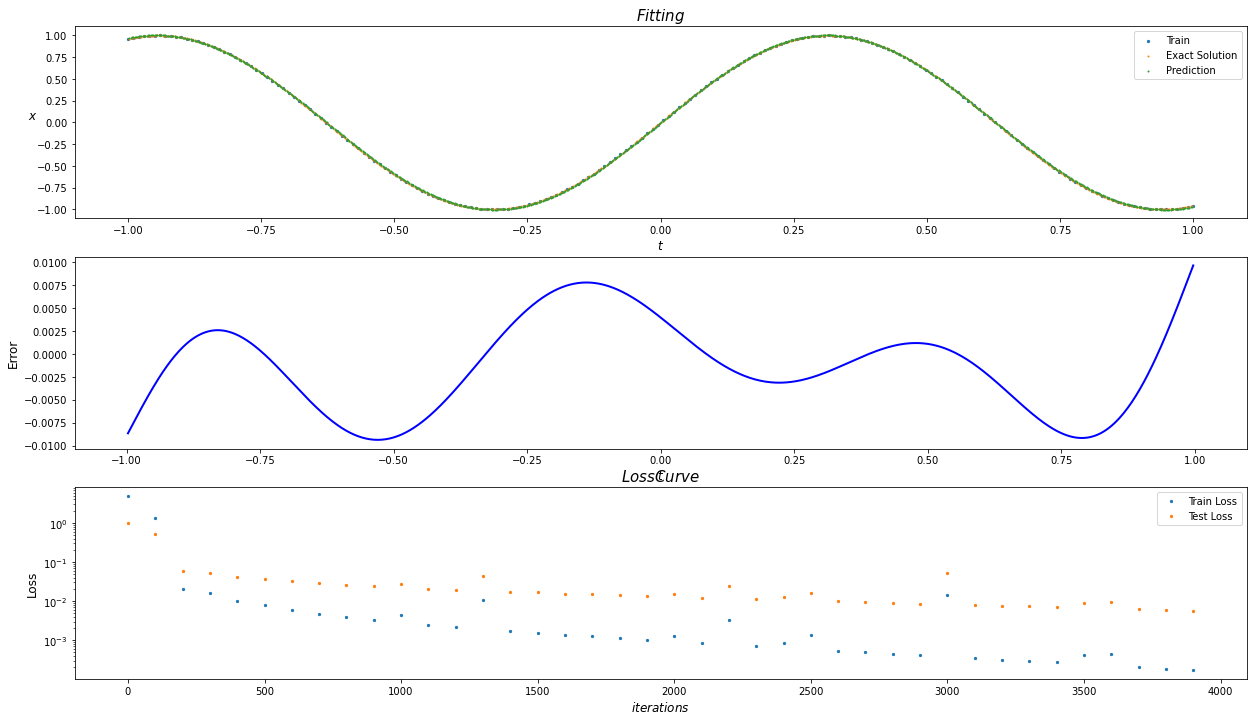

In [4]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################    
fig = plt.figure(figsize=(21, 12))

ax = plt.subplot(311)
ax.scatter(t_train, x_train, s=5, label="Train")
ax.scatter(t_test, x_test, s=1, label="Exact Solution")
ax.scatter(t_test, model.net(t_test), s=1, label="Prediction")
ax.legend()
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("$x$", fontsize = 12, rotation = 0)
ax.set_title("$Fitting$", fontsize = 15)

ax = plt.subplot(312)
ax.plot(t_test, x_test - model.net(t_test), "b-", linewidth = 2)
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("Error", fontsize = 12, rotation = 90)

ax = plt.subplot(313)
loss_train = np.array(model.loss_history["train"])
loss_test = np.array(model.loss_history["test"])
ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=5, label="Train Loss")
ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=5, label="Test Loss")
ax.legend()
ax.set_xlabel("$iterations$", fontsize = 12)
ax.set_ylabel("Loss", fontsize = 12, rotation = 90)
ax.set_yscale("log")
ax.set_title('$Loss Curve$', fontsize = 15)